In [1]:
import theano
import theano.tensor as T
import lasagne as L

from theano.printing import Print as TPP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from IPython import display

from util import iterate_minibatches
from loadmnist import load_data

%matplotlib inline

Using gpu device 0: Tesla M2090 (CNMeM is disabled, cuDNN not available)


In [2]:
input_var = T.vector()

In [3]:
X_train, y_train, X_val, y_val = load_data(test_size=0.2)

In [4]:
class NeuralNetwork:
    def __init__(self, n_input, n_hidden, n_target, theta=None, input_var=None, target_var=None):
        self.input_var = input_var or T.matrix('mnist input')
        self.target_var = target_var or T.ivector('mnist target')

        self.theta = theta or T.vector('theta')
        
        self.W1 = T.reshape(self.theta[:n_input * n_hidden], (n_input, n_hidden))
        self.b1 = self.theta[n_input * n_hidden:(n_input + 1) * n_hidden]
        self.W2 = T.reshape(self.theta[(n_input + 1) * n_hidden:(n_input + 1) * n_hidden + n_hidden * n_target], (n_hidden, n_target))
        self.b2 = self.theta[(n_input + 1) * n_hidden + n_hidden * n_target:(n_input + 1) * n_hidden + (n_hidden + 1) * n_target]

        l_input = L.layers.InputLayer(shape=(None, n_input), input_var=input_var)
        l_dense = L.layers.DenseLayer(l_input, 
                                      num_units=n_hidden, 
                                      W=self.W1, b=self.b1,
                                      nonlinearity=L.nonlinearities.sigmoid)
        l_softmax = L.layers.DenseLayer(l_dense,
                                       num_units=n_target,
                                       W=self.W2, b=self.b2,
                                       nonlinearity=L.nonlinearities.softmax)
        
        prediction = L.layers.get_output(l_softmax)
        prediction = T.clip(prediction, 1e-5, 1. - 1e-5)
        self.loss = L.objectives.categorical_crossentropy(prediction, self.target_var).mean()
        
        self.func = self.loss
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.input_var, self.target_var]

In [5]:
mnist_input_var = T.matrix('mnist input')
mnist_target_var = T.ivector('mnist target')
    
n_input = 784
n_hidden = 20
n_target = 10
    
func = lambda theta: NeuralNetwork(n_input, n_hidden, n_target, 
                                   theta=theta, 
                                   input_var=mnist_input_var, 
                                   target_var=mnist_target_var).func

In [6]:
%run stochastic_lstm_optimizer_multilayer.py

In [7]:
def build_net(func, n_steps, n_hidden=20, gradient_steps=-1, n_gac=0, n_layers=2, grad_clip=0):
    l_input = L.layers.InputLayer(shape=(None,), input_var=input_var)
    l_optim = LSTMOptimizerLayer(l_input, 
                                 num_units=n_hidden, 
                                 n_steps=n_steps, 
                                 function=func, 
                                 gradient_steps=gradient_steps, 
                                 n_gac=n_gac, n_layers=n_layers, 
                                 grad_clipping=grad_clip,
                                 preprocess_input=True, scale_output=0.1)
    return l_optim

In [8]:
class LSTMOptimizer:
    def __init__(self, input_var, func, func_params, n_hidden=20, gradient_steps=20, n_gac=0, n_layers=2, loss_type='sum'):
        n_steps = T.iscalar()
        kwargs = {
            'gradient_steps': gradient_steps,
            'n_gac': n_gac,
            'n_layers': n_layers,
            'n_hidden': n_hidden,
            'grad_clip': 0,
        }
        self.l_optim = build_net(func, n_steps, **kwargs)
        
        theta_history, loss_history, grads_history = L.layers.get_output(self.l_optim)
        if loss_type == 'sum':
            loss = loss_history.sum()
        elif loss_type == 'prod':
            loss = np.log(loss_history[1:]).sum()
        else:
            raise ValueError("loss_type should be one of ('sum', 'prod')")
        
        self.lr = theano.shared(np.array(0.01, dtype=np.float32))

        params = L.layers.get_all_params(self.l_optim)
        updates = L.updates.adam(loss, params, learning_rate=self.lr)
        
        self.loss_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history, grads_history], allow_input_downcast=True)
        self.train_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history, grads_history], updates=updates, allow_input_downcast=True)
        
    def train(self, sample_function, sample_point, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.96):
        for i in range(n_epochs):
            t = time.time()    

            training_loss_history = []
            for j in range(batch_size):
                params = sample_function()
                theta = sample_point()
                
                theta_history, loss_history, grads_out = self.train_fn(theta, n_iter, *params)
                loss = sum(loss_history)
                training_loss_history.append(loss_history)

            display.clear_output(wait=True)
            plt.semilogy(np.median(training_loss_history, axis=0))
            plt.show()
            print("Epoch number {}".format(i))
            t = time.time() - t

            print("Time on epoch {}: {}".format(i, t))
            print("Loss on {}: {}; {}".format(i, loss, np.median(training_loss_history, axis=0)[-1]))

            self.lr.set_value((self.lr.get_value() * decay_rate).astype(np.float32))
            
    def optimize(self, theta, func_params, n_iter):
        return self.loss_fn(theta, n_iter, *func_params)
    
    def get_updates(self, loss, params):
        return self.l_optim.get_updates(loss, params)

In [9]:
def sgd_step(theta, lr):
    f = func(theta)
    g = theano.grad(f, theta)
    return theta - lr * g, f

n_steps = T.iscalar()

sgd_lr = T.scalar()
sgd_thetas, sgd_losses = theano.scan(fn=sgd_step,
                                        outputs_info=[input_var, None],
                                                      non_sequences=sgd_lr,
                                                      n_steps=n_steps)[0]

sgd_fn = theano.function([input_var, n_steps, sgd_lr, mnist_input_var, mnist_target_var], [sgd_thetas, sgd_losses], allow_input_downcast=True)

In [10]:
def momentum_step(theta, old_grad, lr, mu):
    f = func(theta)
    g = theano.grad(f, theta)
    new_grad = mu * old_grad + TPP('grad:', ('var',))(g)
    return theta - lr * new_grad, f, new_grad

momentum_steps = T.iscalar()
momentum_mu = T.scalar()

momentum_thetas, momentum_losses, _ = theano.scan(fn=momentum_step,
                                                  outputs_info=[input_var, None, T.zeros_like(input_var)],
                                                  non_sequences=[sgd_lr, momentum_mu],
                                                  n_steps=n_steps)[0]

momentum_fn = theano.function([input_var, n_steps, sgd_lr, mnist_input_var, mnist_target_var], [momentum_thetas, momentum_losses], allow_input_downcast=True, givens={
        momentum_mu: np.cast['float32'](0.9),
    })

In [11]:
lstm_optimizer = LSTMOptimizer(input_var, func, [mnist_input_var, mnist_target_var], n_hidden=20, gradient_steps=20, n_gac=0, loss_type='prod')

In [12]:
lstm_optimizer_sum = LSTMOptimizer(input_var, func, [mnist_input_var, mnist_target_var], n_hidden=20, gradient_steps=20, n_gac=0)
lstm_gac_optimizer_sum = LSTMOptimizer(input_var, func, [mnist_input_var, mnist_target_var], n_hidden=20, gradient_steps=20, n_gac=5)
# lstm_optimizer_prod = LSTMOptimizer(input_var, func, [mnist_input_var, mnist_target_var], n_hidden=20, gradient_steps=20, n_gac=0, loss_type='prod')
lstm_gac_optimizer_prod = LSTMOptimizer(input_var, func, [mnist_input_var, mnist_target_var], n_hidden=20, gradient_steps=20, n_gac=5, loss_type='prod')

In [13]:
class SampleParams:
    def __init__(self, batch_size=128):
        self.gen = iterate_minibatches(X_train, y_train, batch_size=batch_size, shuffle=True)
        self.ret = next(self.gen)
        self.batch_size = batch_size
        
    def __call__(self):
        try:
            ret = next(self.gen)
        except StopIteration:
            self.gen = iterate_minibatches(X_train, y_train, batch_size=self.batch_size, shuffle=True)
            ret = next(self.gen)
            
        return ret

sample_params = SampleParams(batch_size=128)
    
def sample_point():
    theta = np.random.normal(loc=0.0, scale=1., size=(n_input + 1) * n_hidden + (n_hidden + 1) * n_target)
    return theta

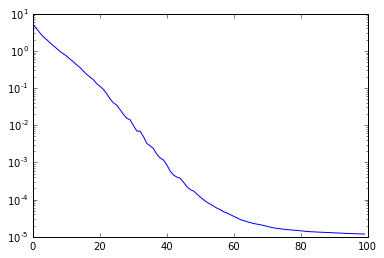

Epoch number 1
Time on epoch 1: 60.787232637405396
Loss on 1: 23.966693124631092; 1.1848378562717699e-05


KeyboardInterrupt: 

In [14]:
lstm_optimizer.train(sample_params, sample_point, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.9)
# lstm_optimizer.train(sample_params, lambda: theta, n_iter=100, n_epochs=50, batch_size=5, decay_rate=0.96)

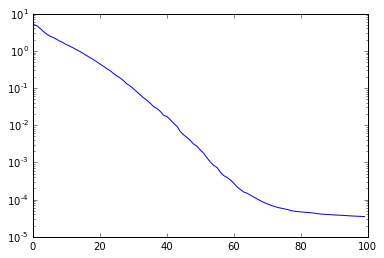

Epoch number 49
Time on epoch 49: 98.0004575252533
Loss on 49: 46.12499915830267; 3.4976757888216525e-05


In [ ]:
lstm_optimizer_sum.train(sample_params, sample_point, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.9)

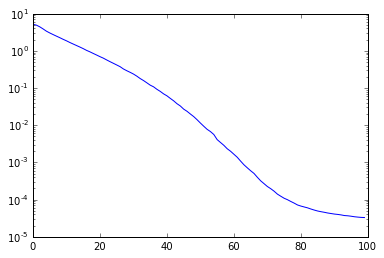

Epoch number 46
Time on epoch 46: 286.9115490913391
Loss on 46: 43.753773299955355; 3.292433757451363e-05


In [ ]:
lstm_gac_optimizer_sum.train(sample_params, sample_point, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.9)

In [ ]:
lstm_gac_optimizer_prod.train(sample_params, sample_point, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.9)

In [17]:
np.savez('lstm_optimizer.npz', *L.layers.get_all_param_values(lstm_optimizer.l_optim))

In [14]:
with np.load('lstm_optimizer.npz') as f:
     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
L.layers.set_all_param_values(lstm_optimizer.l_optim, param_values)

In [ ]:
def shared_neural_network(n_input, n_hidden, n_target, theta=None, input_var=None, target_var=None, nonlin=L.nonlinearities.sigmoid, n_layers=2):
    input_var = input_var or T.matrix('mnist input')
    target_var = target_var or T.ivector('mnist target')

    l_input = L.layers.InputLayer(shape=(None, n_input), input_var=input_var)
    l_dense = l_input
    for _ in range(n_layers):
        l_dense = L.layers.DenseLayer(l_dense, 
                                      num_units=n_hidden, 
                                      nonlinearity=nonlin)
    l_softmax = L.layers.DenseLayer(l_dense,
                                   num_units=n_target,
                                   nonlinearity=L.nonlinearities.softmax)

    prediction = L.layers.get_output(l_softmax)
    prediction = T.clip(prediction, 1e-5, 1. - 1e-5)
    loss = L.objectives.categorical_crossentropy(prediction, target_var).mean()
    
    return loss, l_softmax, input_var, target_var

In [ ]:
class SharedNeuralNetwork:
    def __init__(self, n_input, n_hidden, n_target, nonlin=L.nonlinearities.sigmoid, n_layers=1, get_updates=L.updates.adam):
        nn_loss, nn, shared_input_var, shared_target_var = shared_neural_network(n_input, n_hidden, n_target, nonlin=nonlin, n_layers=n_layers)
#        updates = lstm_optimizer.l_optim.get_updates(nn_loss, L.layers.get_all_params(nn))
        updates = get_updates(nn_loss, L.layers.get_all_params(nn))
        
        self.train_shared_nn_fn = theano.function([shared_input_var, shared_target_var], nn_loss, updates=updates, allow_input_downcast=True)
        self.loss_shared_nn_fn = theano.function([shared_input_var, shared_target_var], nn_loss, allow_input_downcast=True)
        self.nn = nn
        
        nn_out = L.layers.get_output(nn)
        nn_out = T.clip(nn_out, 1e-5, 1. - 1e-5)
        nn_accuracy = L.objectives.categorical_accuracy(nn_out, shared_target_var).mean()

        self.accuracy_shared_nn_fn = theano.function([shared_input_var, shared_target_var], nn_accuracy, allow_input_downcast=True)
        self.prediction_shared_nn_fn = theano.function([shared_input_var], nn_out, allow_input_downcast=True)

    def train(self, n_epochs, batch_size):
        train_loss_history = []
        train_loss_av_history = []
        val_loss_history = []

        train_acc_history = []
        val_acc_history = []

        for epoch in range(n_epochs):
            avg_cost = 0
            batches_per_epoch = 0    
            t = time.time()

            for batch in iterate_minibatches(X_train, y_train, batch_size=batch_size, shuffle=True):
                inputs, targets = batch
                cur_loss = self.train_shared_nn_fn(inputs, targets)

                avg_cost += cur_loss
                train_loss_history.append(cur_loss)

                if batches_per_epoch % 50 == 0:
                    print ("Batch number {}".format(batches_per_epoch))

                batches_per_epoch += 1
            avg_cost /= batches_per_epoch
            train_loss_av_history.append(avg_cost)
                
            avg_cost = 0;
            n_batch = 0

            for batch in iterate_minibatches(X_val, y_val, batch_size=batch_size, shuffle=True):
                inputs, targets = batch
                avg_cost += self.loss_shared_nn_fn(inputs, targets)
                n_batch += 1

            avg_cost /= n_batch
            val_loss_history.append(avg_cost)

            train_acc_history.append(self.accuracy_shared_nn_fn(X_train, y_train))
            val_acc_history.append(self.accuracy_shared_nn_fn(X_val, y_val))

            display.clear_output(wait=True)
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_history, label='train loss')
            plt.plot(range(0, len(val_loss_history) * batches_per_epoch, batches_per_epoch), val_loss_history, label='val loss')

            plt.subplot(1, 2, 2)
            plt.plot(train_acc_history, label='train acc')
            plt.plot(val_acc_history, label='val acc')

            plt.show()
            
        return train_loss_history, train_loss_av_history, val_loss_history, train_acc_history, val_acc_history

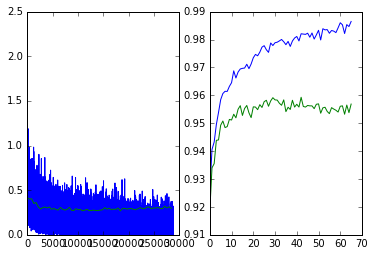

Batch number 0
Batch number 50
Batch number 100
Batch number 150
Batch number 200
Batch number 250
Batch number 300
Batch number 350
Batch number 400


In [ ]:
parameters = [
    (20, 1, L.nonlinearities.sigmoid),
    (40, 1, L.nonlinearities.sigmoid),
    (20, 2, L.nonlinearities.sigmoid),
    (20, 1, L.nonlinearities.rectify),
]

updates_list = {
    'lstm_sum': lstm_optimizer_sum.get_updates,
    'lstm_gac_sum': lstm_gac_optimizer_sum.get_updates,
    'lstm_prod': lstm_optimizer.get_updates,
    'lstm_gac_prod': lstm_gac_optimizer_prod.get_updates,
    'momentum': lambda loss, params: L.updates.momentum(loss, params, learning_rate=1.0, momentum=0.9),
    'adam': lambda loss, params: L.updates.adam(loss, params, learning_rate=0.01)
}

histories = {}

nonlins = {
    L.nonlinearities.sigmoid: 'sigmoid',
    L.nonlinearities.rectify: 'relu'
}

for name, updates in updates_list.items():
    for n_hid, n_layers, nonlin in parameters:
        shared_nn = SharedNeuralNetwork(784, n_hid, 10, nonlin=nonlin, n_layers=n_layers, get_updates=updates)

        batch_size = 128
        n_epochs = 100
        _, train_history, val_history, train_acc_history, val_acc_history = shared_nn.train(n_epochs, batch_size)
        histories["{}; ({}, {}, {})".format(name, n_hid, n_layers, nonlins[nonlin])] = (train_history, val_history, train_acc_history, val_acc_history)

In [ ]:
def plot_with_params(key):
    plt.figure(figsize=(15, 12))

    for name, hist in histories.items():
        train_h, val_h, train_acc_h, val_acc_h = hist

        if name.find(key) == -1:
            continue
        
        if name.find('lstm') != -1:
            linestyle = '-'
        else:
            linestyle = '--'

#         plt.subplot(1, 2, 1)
        plt.title('loss; {}'.format(key))
        plt.semilogy(train_h, label='train loss; {}'.format(name), linestyle=linestyle)
#         plt.semilogy(val_h, label='val loss; {}'.format(name), linestyle=linestyle)
        plt.legend()

#         plt.subplot(1, 2, 2)
#         plt.title('accuracy; {}'.format(key))
#         plt.plot(train_acc_h, label='train accuracy; {}'.format(name), linestyle=linestyle)
#         plt.plot(val_acc_h, label='val accuracy; {}'.format(name), linestyle=linestyle)
#         plt.legend(loc=4)

    plt.show()

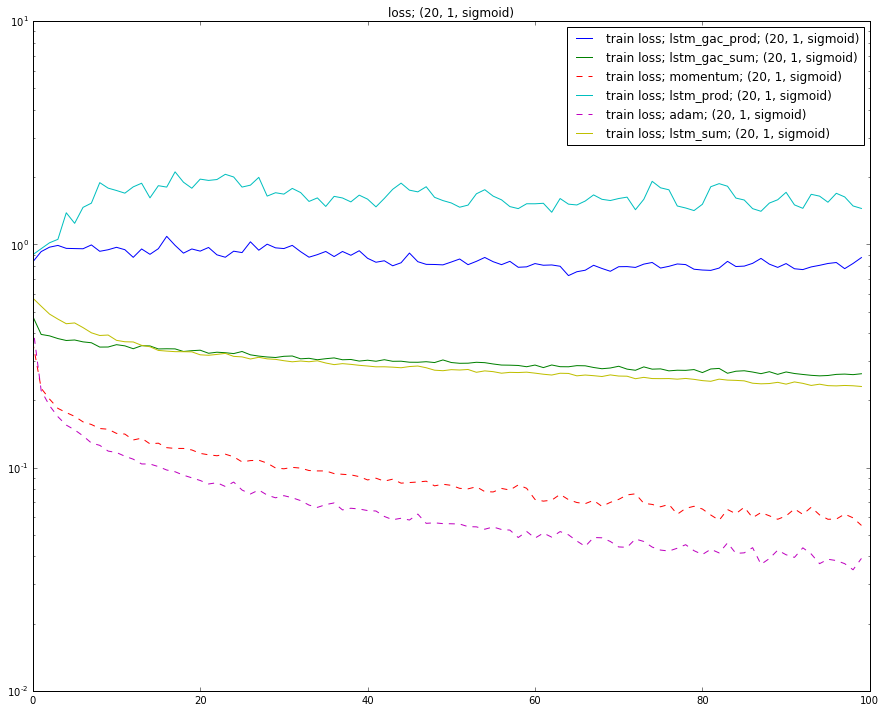

In [26]:
key = "({}, {}, {})".format(20, 1, 'sigmoid')
plot_with_params(key)

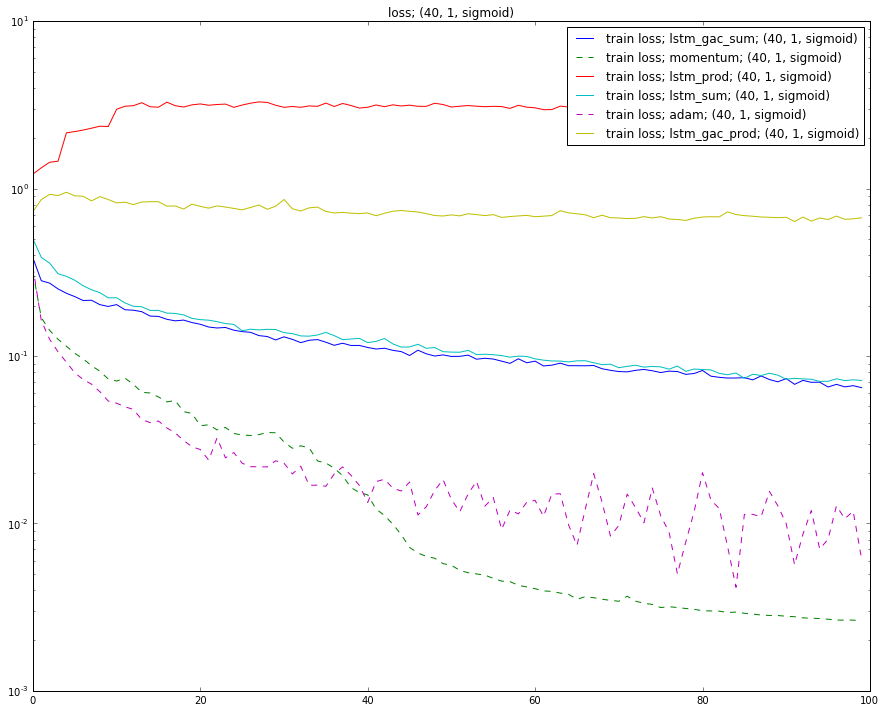

In [27]:
key = "({}, {}, {})".format(40, 1, 'sigmoid')
plot_with_params(key)

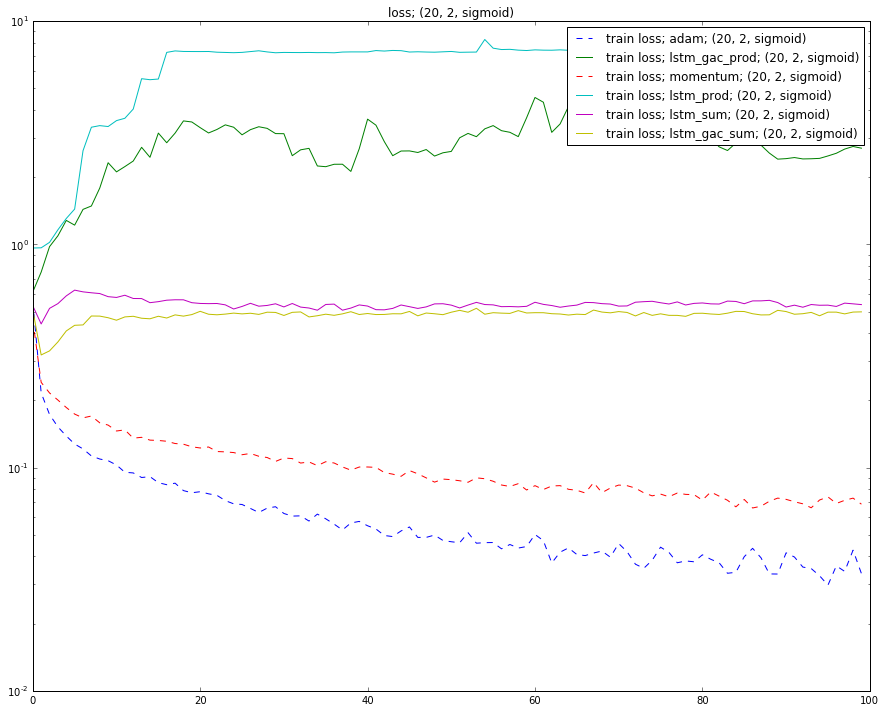

In [28]:
key = "({}, {}, {})".format(20, 2, 'sigmoid')
plot_with_params(key)

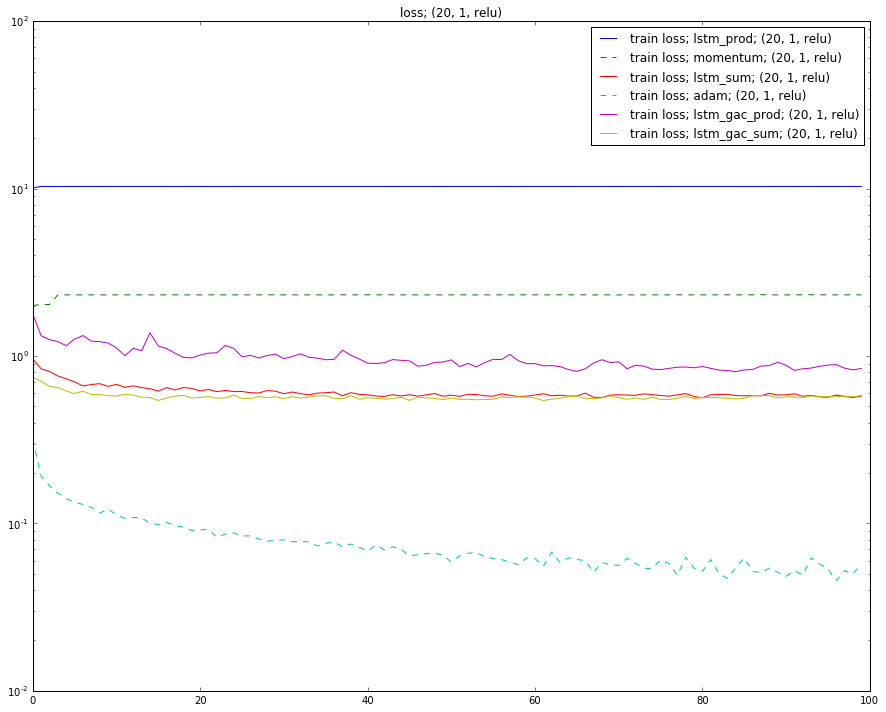

In [29]:
key = "({}, {}, {})".format(20, 1, 'relu')
plot_with_params(key)